# CMR with URPE-Modulated Encoding Drift
Two separable dimensions of "sensitivity":

1. **Amplitude Sensitivity (gain/slope)**: How much encoding drift increases as URPE magnitude increases
2. **Determinism (mapping noise/temperature)**: How reliably the same URPE produces the same encoding drift


- Setup: import libraries and define fixed CMR parameters
- URPE computation
- Modulation: two models (noise-based and gating-based)
- Simulation Functions: encoding, retrieval, trial simulation
- Analysis metrics: serial position curve, lag-CRP, etc.
- Run sweep
- Visualization

---
## Setup & Core Parameters

Import necessary libraries and define all fixed CMR parameters (these will NOT be swept).

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from itertools import product
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline

### List Configuration

**Important**: We use a fixed presentation order (no permutation) so that trial index matches item index. This is critical for aligning URPE with the reward sequence.

In [2]:
# List length
N = 10

# Fixed presentation order: trial index = item index
# This ensures URPE_t corresponds to the t-th item presented
pres_indices = np.arange(N) + 1  # 1-indexed: [1, 2, 3, ..., 10]

### Retrieval Route Weights

CMR combines semantic and episodic retrieval routes. Here we use pure episodic retrieval (no semantic associations).

In [3]:
# Route strengths (relative weights)
sem = 0          # Semantic route strength
episodic = 1     # Episodic route strength

# Normalize to sum to 1
sem_weight = sem / (episodic + sem)
episodic_weight = episodic / (episodic + sem)

print(f"Semantic weight: {sem_weight:.2f}")
print(f"Episodic weight: {episodic_weight:.2f}")

Semantic weight: 0.00
Episodic weight: 1.00


### Baseline Encoding Drift Schedule

This is the **baseline** drift schedule before any URPE modulation:
- First item: complete context update (B = 1.0)
- Subsequent items: moderate drift (B = 0.65)

URPE modulation will be **added on top of** this baseline.

In [4]:
# Baseline encoding drift (per serial position)
# This matches the CMR_SEM_annotated.ipynb structure
B_encD_baseline = np.array([1.0, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65])

print("Baseline drift schedule:")
print(B_encD_baseline)

Baseline drift schedule:
[1.   0.65 0.65 0.65 0.65 0.65 0.65 0.65 0.65 0.65]


### Semantic Similarity Matrix

We use an orthogonal (identity) matrix, meaning all items are equally dissimilar semantically.

In [5]:
# Orthogonal semantic representation (all items distinct)
sem_mat = np.eye(N)

### Network Architecture Parameters

These control the CMR network structure and learning rates. **All fixed** during parameter sweep.

In [6]:
# Pre-existing connection strengths
gamma_fc = 0.581  # Strength of pre-existing feature→context associations
eye_fc = 1 - gamma_fc  # Initial self-connections in F→C
eye_cf = 0.0           # Initial self-connections in C→F (typically 0)

# Learning rates during encoding
lrate_fc_enc = gamma_fc  # Feature→context learning rate
lrate_cf_enc = 1.0       # Context→feature learning rate

# Learning rates during retrieval (no new learning)
lrate_fc_rec = 0.0
lrate_cf_rec = 0.0

print(f"γ_FC = {gamma_fc}")
print(f"Encoding learning rates: FC={lrate_fc_enc}, CF={lrate_cf_enc}")
print(f"Retrieval learning rates: FC={lrate_fc_rec}, CF={lrate_cf_rec}")

γ_FC = 0.581
Encoding learning rates: FC=0.581, CF=1.0
Retrieval learning rates: FC=0.0, CF=0.0


### Accumulator Parameters

These control the decision dynamics during retrieval. **All fixed** during parameter sweep.

In [7]:
# Accumulator noise and dynamics
eta = 0.30        # Noise magnitude
K = 0.20          # Decay rate (self-inhibition)
L = 0.20          # Lateral inhibition strength
tau = 10.0        # Time constant (ms)
dt = 10.0         # Time step (ms)
threshold = 1.0   # Retrieval threshold
rec_time = 90000  # Maximum retrieval duration (ms)

print(f"Noise (η): {eta}")
print(f"Decay (K): {K}")
print(f"Lateral inhibition (L): {L}")
print(f"Time constant (τ): {tau} ms")
print(f"Time step (dt): {dt} ms")
print(f"Threshold: {threshold}")
print(f"Max retrieval time: {rec_time} ms")

Noise (η): 0.3
Decay (K): 0.2
Lateral inhibition (L): 0.2
Time constant (τ): 10.0 ms
Time step (dt): 10.0 ms
Threshold: 1.0
Max retrieval time: 90000 ms


### Trial-Indexed Reward Sequence

This is the reward sequence that drives URPE computation. Rewards are indexed by **trial** (temporal order), not item identity.

Example: 5 low-reward trials followed by 5 high-reward trials.

In [8]:
# Trial-indexed rewards (length N)
# This creates a reward structure with a boundary at position 5
rewards = np.array([10, 10, 10, 10, 10, 20, 20, 20, 20, 20], dtype=float)

print("Reward sequence (by trial):")
print(rewards)
print(f"\nReward boundary at position {np.where(np.diff(rewards) != 0)[0][0] + 1}")

Reward sequence (by trial):
[10. 10. 10. 10. 10. 20. 20. 20. 20. 20.]

Reward boundary at position 5


---
## Reward Prediction Error Computation

2024 unsigned reward prediction error (URPE):
$$\text{URPE}_t = |r_t - V_t|$$

with a value learner:
$$V_{t+1} = V_t + \alpha (r_t - V_t)$$

This measures the **magnitude of surprise** at each trial outcome.

In [9]:
def compute_urpe_sequence(rewards, alpha=0.2, V0=None):
    """
    Compute unsigned reward prediction error (URPE) for a sequence of rewards.
    
    This implements a simple value learning model where:
    1. The agent maintains an estimate V of expected reward
    2. After each trial, V is updated based on the prediction error
    3. URPE captures the magnitude of surprise (unsigned prediction error)
    
    Parameters
    ----------
    rewards : array-like, shape (N,)
        Trial-indexed rewards (temporal order)
    alpha : float, default=0.2
        Value learning rate (0 < α ≤ 1)
        - Larger α: faster adaptation to new rewards
        - Smaller α: slower adaptation, more averaging
    V0 : float or None
        Initial value estimate
        If None, initialized to first reward
    
    Returns
    -------
    urpe : ndarray, shape (N,)
        Unsigned prediction error at each trial: |r_t - V_t|
    srpe : ndarray, shape (N,)
        Signed prediction error at each trial: r_t - V_t
        (useful for debugging)
    
    Example
    -------
    >>> rewards = np.array([10, 10, 10, 20, 20])
    >>> urpe, srpe = compute_urpe_sequence(rewards, alpha=0.2)
    >>> # URPE will be high at the reward transition (position 3)
    """
    rewards = np.asarray(rewards, dtype=float)
    N = len(rewards)
    
    # Initialize value estimate
    if V0 is None:
        V = float(rewards[0])  # Start with first reward
    else:
        V = float(V0)
    
    # Preallocate output arrays
    urpe = np.zeros(N, dtype=float)  # Unsigned prediction error
    srpe = np.zeros(N, dtype=float)  # Signed prediction error (for debugging)
    
    # Compute URPE for each trial
    for t in range(N):
        r = float(rewards[t])
        
        # Prediction error: actual - expected
        delta = r - V
        
        # Store signed and unsigned prediction errors
        srpe[t] = delta
        urpe[t] = abs(delta)
        
        # Update value estimate for next trial
        V = V + alpha * delta
    
    return urpe, srpe

### Verify that URPE correctly identifies reward transitions.

Trial-by-trial URPE:
Trial    Reward     URPE       SRPE      
1        10.0       0.000      0.000     
2        10.0       0.000      0.000     
3        10.0       0.000      0.000     
4        10.0       0.000      0.000     
5        10.0       0.000      0.000     
6        20.0       10.000     10.000    
7        20.0       8.000      8.000     
8        20.0       6.400      6.400     
9        20.0       5.120      5.120     
10       20.0       4.096      4.096     


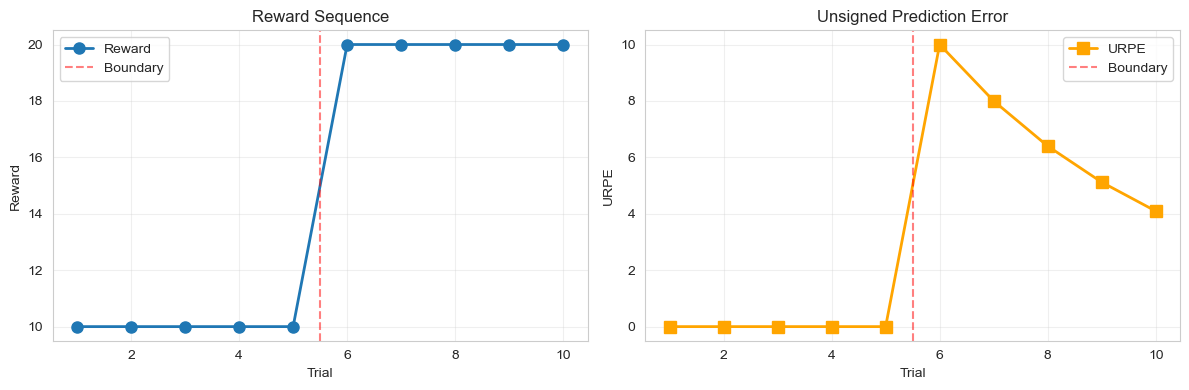


Note: URPE peaks at the reward transition (trial 6)


In [10]:
# Test URPE computation with our reward sequence
urpe_test, srpe_test = compute_urpe_sequence(rewards, alpha=0.2, V0=None)

# Display results
print("Trial-by-trial URPE:")
print("="*60)
print(f"{'Trial':<8} {'Reward':<10} {'URPE':<10} {'SRPE':<10}")
print("="*60)
for t in range(len(rewards)):
    print(f"{t+1:<8} {rewards[t]:<10.1f} {urpe_test[t]:<10.3f} {srpe_test[t]:<10.3f}")
print("="*60)

# Plot URPE over trials
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(range(1, N+1), rewards, 'o-', linewidth=2, markersize=8, label='Reward')
axes[0].axvline(5.5, color='red', linestyle='--', alpha=0.5, label='Boundary')
axes[0].set_xlabel('Trial')
axes[0].set_ylabel('Reward')
axes[0].set_title('Reward Sequence')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(1, N+1), urpe_test, 's-', linewidth=2, markersize=8, color='orange', label='URPE')
axes[1].axvline(5.5, color='red', linestyle='--', alpha=0.5, label='Boundary')
axes[1].set_xlabel('Trial')
axes[1].set_ylabel('URPE')
axes[1].set_title('Unsigned Prediction Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nNote: URPE peaks at the reward transition (trial 6)")

---
## URPE-to-Drift Modulation Functions

These functions map URPE values to encoding drift rates. We implement two models representing different interpretations of "determinism":

### Model A: Noise Model
**Determinism = low mapping noise**
$$B_t = \text{clip}(B^{\text{base}}_t + \kappa \cdot \text{URPE}_t + \mathcal{N}(0, \sigma_B), [B_{\min}, B_{\max}])$$

- **κ (kappa)**: Amplitude sensitivity - how much drift increases per unit URPE
- **σ_B (sigma_B)**: Mapping noise - random variability around the mapping
  - σ_B = 0: deterministic (same URPE → same drift)
  - σ_B > 0: stochastic (same URPE → variable drift)

### Model B: Gating Model
**Determinism = reliability of modulation engagement**
$$p_t = \sigma\left(\frac{\text{URPE}_t - \theta}{\text{temp}}\right)$$
$$B_t = \begin{cases} B^{\text{base}}_t + \kappa \cdot \text{URPE}_t & \text{with probability } p_t \\ B^{\text{base}}_t & \text{with probability } 1-p_t \end{cases}$$

- **κ (kappa)**: Amplitude sensitivity - size of drift change when modulation occurs
- **temp**: Temperature - controls how deterministically URPE triggers modulation
  - temp → 0: deterministic step function (URPE either fully on or off)
  - temp > 0: probabilistic gating (gradual transition)

In [11]:
import numpy as np

def normalize_urpe(urpe, mode="max", eps=1e-8):
    """
    Normalize URPE for *mapping only* (URPE definition itself stays |r - V|).

    mode="max": u = urpe / max(urpe)  -> u in [0, 1]
    mode="none": u = urpe (no scaling; can cause drift blow-up if rewards are large)
    """
    urpe = np.asarray(urpe, dtype=float)
    if mode == "max":
        denom = float(np.max(urpe)) + eps
        return urpe / denom
    elif mode == "none":
        return urpe
    else:
        raise ValueError("urpe_scale_mode must be 'max' or 'none'")

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def urpe_to_Benc_noise_model(
    B_base,
    urpe,
    kappa=0.0,
    sigma_B=0.0,
    rng=None,
    urpe_scale_mode="max",
    B_min=0.0,
    B_max=1.0
):
    """
    Additive-noise mapping (determinism = low sigma_B):

      u_t = normalize_urpe(URPE_t)
      B_t = clip(B_base[t] + kappa * u_t + Normal(0, sigma_B), [B_min, B_max])

    Interpretation:
      - kappa controls *amplitude sensitivity* (max drift increment if u in [0,1])
      - sigma_B controls *mapping stochasticity* (0 = deterministic)
    """
    B_base = np.asarray(B_base, dtype=float)
    u = normalize_urpe(urpe, mode=urpe_scale_mode)

    if rng is None:
        rng = np.random.default_rng(0)

    noise = rng.normal(0.0, sigma_B, size=len(u)) if sigma_B > 0 else 0.0
    B = B_base + kappa * u + noise
    return np.clip(B, B_min, B_max)

def urpe_to_Benc_gating_model(
    B_base,
    urpe,
    kappa=0.0,
    theta=0.5,
    temp=0.1,
    rng=None,
    urpe_scale_mode="max",
    B_min=0.0,
    B_max=1.0,
    use_soft_gate=True
):
    """
    Gating mapping (determinism = low temp):

      u_t = normalize_urpe(URPE_t)
      p_t = sigmoid((u_t - theta) / temp)

    Two options:
      - use_soft_gate=True:
          B_t = B_base[t] + (kappa * u_t) * p_t    (deterministic expectation)
      - use_soft_gate=False:
          gate_t ~ Bernoulli(p_t)
          B_t = B_base[t] + kappa * u_t  if gate_t else B_base[t]

    Interpretation:
      - kappa controls *amplitude sensitivity* when modulation is engaged
      - theta sets where p_t=0.5 in normalized-URPE units (0..1 if urpe_scale_mode='max')
      - temp controls *how deterministic* gating is:
          small temp -> step-like, large temp -> gradual/uncertain
    """
    B_base = np.asarray(B_base, dtype=float)
    u = normalize_urpe(urpe, mode=urpe_scale_mode)

    if rng is None:
        rng = np.random.default_rng(0)

    temp = max(float(temp), 1e-6)
    p = sigmoid((u - float(theta)) / temp)

    if use_soft_gate:
        B = B_base + (kappa * u) * p
    else:
        on = rng.random(len(u)) < p
        B = B_base.copy()
        B[on] = B_base[on] + kappa * u[on]

    return np.clip(B, B_min, B_max)


### Visualize Mapping Functions

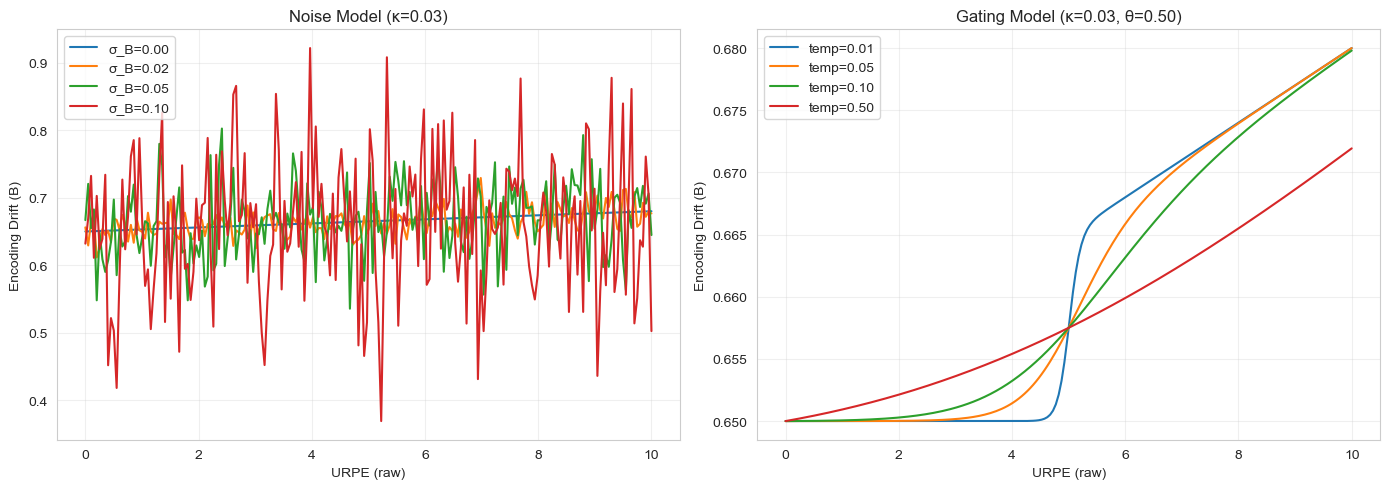

In [12]:
# Visualize how URPE maps to drift for the two models (mapping only; not running full CMR)

urpe_range = np.linspace(0, 10, 200)                      # raw URPE values
B_base_constant = np.full_like(urpe_range, 0.65)          # constant baseline drift
rng_test = np.random.default_rng(42)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ===== Noise Model: vary sigma_B with fixed kappa =====
ax = axes[0]
kappa_fixed = 0.03
for sigma in [0.0, 0.02, 0.05, 0.10]:
    B_mapped = urpe_to_Benc_noise_model(
        B_base_constant, urpe_range,
        kappa=kappa_fixed, sigma_B=sigma,
        rng=rng_test,
        urpe_scale_mode="max",
        B_min=0.0, B_max=1.0
    )
    ax.plot(urpe_range, B_mapped, label=f"σ_B={sigma:.2f}")

ax.set_title(f"Noise Model (κ={kappa_fixed:.2f})")
ax.set_xlabel("URPE (raw)")
ax.set_ylabel("Encoding Drift (B)")
ax.legend()
ax.grid(alpha=0.3)

# ===== Gating Model: vary temp with fixed kappa and a meaningful theta =====
ax = axes[1]
theta_fixed = 0.5  # in normalized-URPE units (0..1 when urpe_scale_mode='max')
for temp in [0.01, 0.05, 0.10, 0.50]:
    B_mapped = urpe_to_Benc_gating_model(
        B_base_constant, urpe_range,
        kappa=kappa_fixed, theta=theta_fixed, temp=temp,
        rng=rng_test,
        urpe_scale_mode="max",
        use_soft_gate=True,
        B_min=0.0, B_max=1.0
    )
    ax.plot(urpe_range, B_mapped, label=f"temp={temp:.2f}")

ax.set_title(f"Gating Model (κ={kappa_fixed:.2f}, θ={theta_fixed:.2f})")
ax.set_xlabel("URPE (raw)")
ax.set_ylabel("Encoding Drift (B)")
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


#### Observations
- Noise model: Higher σ_B adds random scatter around the linear trend
- Gating model: Higher temp makes the transition more gradual
- Both models: κ controls the slope/amplitude of modulation

---
## CMR Simulation Functions

### Context Update Function

$\mathbf{c}_{t+1} = \rho_t \mathbf{c}_t + B_t \mathbf{c}_{\text{in},t}$

(ρ is chosen to maintain unit length)

In [13]:
def context_update(c_old, c_in, B):
    """
    Update context vector using drift dynamics.
    
    Parameters
    ----------
    c_old : ndarray, shape (N, 1)
        Previous context state
    c_in : ndarray, shape (N, 1)
        Input to context (normalized)
    B : float
        Drift rate (0 ≤ B ≤ 1)
        - B = 0: no change (context frozen)
        - B = 1: complete replacement
        - 0 < B < 1: partial update
    
    Returns
    -------
    c_new : ndarray, shape (N, 1)
        Updated context vector (unit length)
    """
    # Compute overlap between old context and input
    dot = float(c_old.T @ c_in)
    
    # Compute scaling factor to maintain unit length
    # ρ is chosen so that ||ρ*c_old + B*c_in|| = 1
    rho = np.sqrt(1 + (B**2) * ((dot**2) - 1)) - B * dot
    
    # Update context
    c_new = rho * c_old + B * c_in
    
    return c_new

### Single Trial Simulation

Simulate one complete encoding-retrieval trial with URPE-modulated drift..

The encoding loop uses URPE-modulated drift rates instead of the fixed baseline schedule.

In [14]:
def simulate_single_trial(
    B_rec,
    rng,
    rewards=None,
    rl_alpha=0.2,
    kappa=0.0,
    det_param=0.0,
    mapping_mode="noise",
    theta=0.5,
    urpe_scale_mode="max",
    use_soft_gate=True,
    record_diagnostics=False
):
    """
    Parameters
    ----------
    B_rec : float
        Context drift rate during retrieval (fixed parameter)
    rng : numpy.random.Generator
        Random number generator for reproducibility
    rewards : array-like or None, shape (N,)
        Trial-indexed reward sequence
        If None, uses baseline drift (no URPE modulation)
    rl_alpha : float, default=0.2
        Value learning rate for URPE computation
    kappa : float, default=0.0
        Amplitude sensitivity (gain)
        How much drift increases per unit URPE
    det_param : float, default=0.0
        Determinism parameter
        - For noise model: sigma_B (mapping noise)
        - For gating model: temp (gating temperature)
    mapping_mode : {'noise', 'gating'}
        Which URPE→drift mapping to use
    record_diagnostics : bool, default=False
        If True, record cue advantage diagnostics
    
    Returns
    -------
    recalls : ndarray, shape (N,)
        Serial positions recalled (1-indexed, 0 = no recall)
    times : ndarray, shape (N,)
        Retrieval times for each recall (ms)
    net_w_fc : ndarray, shape (N, N)
        Feature→context weight matrix after encoding
    net_w_cf : ndarray, shape (N, N)
        Context→feature weight matrix after encoding
    diagnostics : dict or None
        Cue advantage measurements (if record_diagnostics=True)
    """
    
    # ========== SETUP ==========
    
    # Determine encoding drift schedule
    B_base = np.array(B_encD_baseline, dtype=float)  # Baseline drift
    
    if rewards is None:
        # No URPE modulation: use baseline drift
        B_enc_use = B_base
        urpe = None
    else:
        # Compute URPE from reward sequence
        urpe, srpe = compute_urpe_sequence(rewards, alpha=rl_alpha, V0=rewards[0])
        
        # Map URPE to drift modulation
        if mapping_mode == "noise":
            B_enc_use = urpe_to_Benc_noise_model(
                B_base, urpe, 
                kappa=kappa, 
                sigma_B=det_param,  # det_param is sigma_B in noise model
                rng=rng, 
                B_min=0.0, 
                B_max=1.0,
                urpe_scale_mode=urpe_scale_mode
            )
        elif mapping_mode == "gating":
            B_enc_use = urpe_to_Benc_gating_model(
                B_base, urpe,
                kappa=kappa,
                theta=theta,  # Fixed threshold in normalized URPE units
                temp=det_param,  # det_param is temp in gating model
                rng=rng,
                urpe_scale_mode=urpe_scale_mode,
                use_soft_gate=use_soft_gate,
                B_min=0.0,
                B_max=1.0
            )
        else:
            raise ValueError("mapping_mode must be 'noise' or 'gating'")
    
    # Faithfulness check: when kappa=0 and no noise, should recover baseline
    if rewards is not None and kappa == 0.0:
        if (mapping_mode == "noise" and det_param == 0.0):
            assert np.allclose(B_enc_use, B_base), \
                "Sanity check failed: kappa=0 and sigma=0 should recover baseline"
    
    # ========== INITIALIZATION ==========
    
    # Initialize network layers
    net_f = np.zeros((N, 1))  # Feature layer
    net_c = np.zeros((N, 1))  # Context layer
    
    # Initialize weight matrices
    net_w_fc = np.eye(N) * eye_fc  # Feature→context weights
    net_w_cf = np.eye(N) * eye_cf  # Context→feature weights
    
    # ========== ENCODING PHASE ==========
    
    for item_idx in range(N):
        # Get item to present (0-indexed)
        # Since pres_indices = [1,2,3,...,N], this is just item_idx
        feature_idx = pres_indices[item_idx] - 1
        
        # Activate current item in feature layer
        net_f = np.zeros((N, 1))
        net_f[feature_idx] = 1.0
        
        # Compute context input from current feature
        net_c_in = net_w_fc @ net_f
        
        # Normalize context input to unit length
        net_c_in = net_c_in / float(np.sqrt(net_c_in.T @ net_c_in))
        
        # Update context with URPE-modulated drift
        # **KEY MODIFICATION**: Use B_enc_use instead of B_encD
        B = B_enc_use[item_idx]  # Trial-specific drift rate
        net_c = context_update(net_c, net_c_in, B)
        
        # Update associative weights (Hebbian learning)
        # Feature→context: associate current feature with current context
        net_w_fc += (net_c @ net_f.T) * lrate_fc_enc
        
        # Context→feature: associate current context with current feature
        net_w_cf += (net_f @ net_c.T) * lrate_cf_enc
    
    # ========== RETRIEVAL SETUP ==========
    
    # Initialize retrieval tracking
    recalls = np.zeros((N, 1))  # Recalled items
    times = np.zeros((N, 1))    # Retrieval times
    retrieved = np.zeros((N, 1), dtype=bool)  # Which items have been recalled
    thresholds = np.ones((N, 1)) * threshold  # Retrieval thresholds
    
    # Combined retrieval cue (episodic + semantic routes)
    # This determines how context activates features
    net_weights = episodic_weight * net_w_cf + sem_weight * sem_mat
    
    # Time tracking
    time_passed = 0.0
    recall_count = 0
    
    # Diagnostic tracking (for cue advantage analysis)
    if record_diagnostics:
        deltas_all = []
        deltas_by_pos = defaultdict(list)
        delta_forward = []
        delta_backward = []
        pending = None
    
    # ========== RETRIEVAL LOOP ==========
    
    while time_passed < rec_time:
        
        # Compute feature activation from current context
        f_in = net_weights @ net_c
        
        # Setup accumulator simulation
        max_cycles = int((rec_time - time_passed) / dt)
        dt_tau = dt / tau
        sq_dt_tau = np.sqrt(dt_tau)
        
        # Pre-generate noise for all accumulator cycles
        noise = rng.normal(0, eta * sq_dt_tau, size=(N, max_cycles))
        
        # Lateral inhibition matrix (all items inhibit each other except self)
        eyeI = ~np.eye(N, dtype=bool)
        lmat = eyeI.astype(float) * L
        
        # Initialize accumulators
        x = np.zeros((N, 1))  # Accumulator activations
        K_array = np.ones((N, 1)) * K  # Decay rates
        inds = np.arange(N)  # Item indices
        
        # Flags
        crossed = 0  # Has any accumulator crossed threshold?
        i = 0  # Cycle counter
        
        # Run accumulator dynamics until threshold crossed or time runs out
        while i < max_cycles and crossed == 0:
            
            # Compute inhibition and decay
            lx = lmat @ x  # Lateral inhibition from other items
            kx = K_array * x  # Self-decay
            
            # Update accumulator activations (stochastic drift-diffusion)
            # dx/dt = (input - decay - inhibition) + noise
            x = x + ((f_in - kx - lx) * dt_tau + noise[:, i:i+1])
            
            # No negative activations
            x[x < 0] = 0
            
            # Reset previously retrieved items (prevent repetitions)
            reset_these = retrieved & (x >= thresholds)
            x[reset_these] = 0.95 * thresholds[reset_these]
            
            # Check for threshold crossing
            retrievable = ~retrieved
            if np.any(x[retrievable] >= thresholds[retrievable]):
                crossed = 1
                temp_win = x[retrievable] >= thresholds[retrievable]
                temp_ind = inds[retrievable.flatten()]
                winners = temp_ind[temp_win.flatten()]
                
                # Random tiebreaker if multiple items cross simultaneously
                if len(winners) > 1:
                    winners = np.array([rng.choice(winners)])
            
            i += 1
        
        # Update elapsed time
        time_passed += i * dt
        
        # ========== PROCESS RETRIEVAL ==========
        
        if crossed == 1:
            winner = int(winners[0])
            
            # Find serial position of retrieved item
            serial_pos0 = np.where(pres_indices - 1 == winner)[0][0]  # 0-indexed
            serial_pos1 = serial_pos0 + 1  # 1-indexed
            
            # Record diagnostics if requested
            if record_diagnostics and pending is not None:
                prev_pos0 = pending["serial_pos0"]
                delta_f_prev = pending["delta_f"]
                transition = serial_pos0 - prev_pos0
                
                if transition == 1:
                    delta_forward.append(delta_f_prev)
                elif transition == -1:
                    delta_backward.append(delta_f_prev)
                
                pending = None
            
            # Reactivate retrieved item
            net_f = np.zeros((N, 1))
            net_f[winner] = 1.0
            
            # Update context based on retrieved item
            net_c_in = net_w_fc @ net_f
            net_c_in = net_c_in / float(np.sqrt(net_c_in.T @ net_c_in))
            
            # Context drift during retrieval (fixed at B_rec)
            net_c = context_update(net_c, net_c_in, B_rec)
            
            # Update weights (typically zero learning during retrieval)
            net_w_fc += (net_c @ net_f.T) * lrate_fc_rec
            net_w_cf += (net_f @ net_c.T) * lrate_cf_rec
            
            # Record recall
            recall_count += 1
            recalls[recall_count - 1, 0] = serial_pos1
            times[recall_count - 1, 0] = time_passed
            
            # Compute cue advantage diagnostics if needed
            if record_diagnostics:
                left_pos0 = serial_pos0 - 1
                right_pos0 = serial_pos0 + 1
                
                # Check if both neighbors are available
                if 0 <= left_pos0 < N and 0 <= right_pos0 < N:
                    left_item = pres_indices[left_pos0] - 1
                    right_item = pres_indices[right_pos0] - 1
                    
                    if (not retrieved[left_item]) and (not retrieved[right_item]):
                        f_after = (net_weights @ net_c).flatten()
                        delta_f = f_after[right_item] - f_after[left_item]
                        
                        deltas_all.append(delta_f)
                        deltas_by_pos[serial_pos1].append(delta_f)
                        pending = {"serial_pos0": serial_pos0, "delta_f": delta_f}
            
            # Mark item as retrieved
            retrieved[winner] = True
    
    # ========== COMPILE RESULTS ==========
    
    diagnostics = None
    if record_diagnostics:
        diagnostics = {
            "deltas_all": deltas_all,
            "deltas_by_pos": dict(deltas_by_pos),
            "delta_forward": delta_forward,
            "delta_backward": delta_backward
        }
    
    return recalls.flatten(), times.flatten(), net_w_fc, net_w_cf, diagnostics

### Multi-trial simulation

In [15]:
def run_simulation(
    B_rec,
    n_sims=100,
    seed=2026,
    rewards=None,
    rl_alpha=0.2,
    kappa=0.0,
    det_param=0.0,
    mapping_mode="noise",
    theta=0.5,
    urpe_scale_mode="max",
    use_soft_gate=True
):
    """
    Run multiple independent trials with the same parameters.
    
    Parameters
    ----------
    B_rec : float
        Context drift during retrieval
    n_sims : int, default=100
        Number of independent simulations
    seed : int, default=2026
        Random seed for reproducibility
    rewards : array-like or None
        Trial-indexed reward sequence
    rl_alpha : float, default=0.2
        Value learning rate
    kappa : float, default=0.0
        Amplitude sensitivity
    det_param : float, default=0.0
        Determinism parameter (sigma_B or temp)
    mapping_mode : {'noise', 'gating'}
        URPE→drift mapping model
    
    Returns
    -------
    recall_sims : ndarray, shape (N, n_sims)
        Recall sequences for all simulations
    times_sims : ndarray, shape (N, n_sims)
        Retrieval times for all simulations
    net_w_fc : ndarray, shape (N, N)
        Final feature→context weights (from last simulation)
    net_w_cf : ndarray, shape (N, N)
        Final context→feature weights (from last simulation)
    """
    rng = np.random.default_rng(seed)
    
    # Preallocate result arrays
    recall_sims = np.zeros((N, n_sims), dtype=int)
    times_sims = np.zeros((N, n_sims), dtype=float)
    
    # Run simulations
    for s in range(n_sims):
        recalls, times, net_w_fc, net_w_cf, _ = simulate_single_trial(
            B_rec=B_rec,
            rng=rng,
            rewards=rewards,
            rl_alpha=rl_alpha,
            kappa=kappa,
            det_param=det_param,
            mapping_mode=mapping_mode,
            theta=theta,
            urpe_scale_mode=urpe_scale_mode,
            use_soft_gate=use_soft_gate,
            record_diagnostics=False
        )
        
        recall_sims[:, s] = recalls.astype(int)
        times_sims[:, s] = times
    
    return recall_sims, times_sims, net_w_fc, net_w_cf

---
## Analysis Metrics

In [16]:
def compute_spc(recall_sims, N):
    """
    Compute Serial Position Curve (SPC).
    
    The SPC measures the probability that each list item is recalled
    (regardless of output position).
    
    Parameters
    ----------
    recall_sims : ndarray, shape (N, n_sims)
        Recall sequences (serial positions 1-N, 0 = no recall)
    N : int
        List length
    
    Returns
    -------
    spc : ndarray, shape (N,)
        Probability of recall for each serial position
    """
    spc = np.zeros(N)
    for j in range(1, N + 1):
        # P(recall position j)
        spc[j - 1] = np.mean(np.any(recall_sims == j, axis=0))
    return spc


def compute_pfr(recall_sims, N):
    """
    Compute Probability of First Recall (PFR).
    
    The PFR measures the probability that each list item is recalled
    FIRST (i.e., initiates the recall sequence).
    
    Parameters
    ----------
    recall_sims : ndarray, shape (N, n_sims)
        Recall sequences
    N : int
        List length
    
    Returns
    -------
    pfr : ndarray, shape (N,)
        Probability of first recall for each serial position
    """
    pfr = np.zeros(N)
    for j in range(1, N + 1):
        # P(first recall is position j)
        pfr[j - 1] = np.mean(recall_sims[0, :] == j)
    return pfr


def compute_lag_crp(recall_sims, N, max_lag=None):
    """
    Compute Lag-Conditional Response Probability (lag-CRP).
    
    The lag-CRP measures the probability of transitioning from serial
    position i to position i+lag during recall.
    
    Parameters
    ----------
    recall_sims : ndarray, shape (N, n_sims)
        Recall sequences
    N : int
        List length
    max_lag : int or None
        Maximum lag to compute (default: N-1)
    
    Returns
    -------
    lag_vals : ndarray
        Lag values (negative = backward, positive = forward)
    lag_probs : ndarray
        Conditional probability for each lag
    """
    if max_lag is None:
        max_lag = N - 1
    
    # Count transitions and possible transitions for each lag
    lag_counts = defaultdict(int)
    lag_possible = defaultdict(int)
    
    n_sims = recall_sims.shape[1]
    
    for s in range(n_sims):
        recalls = recall_sims[:, s]
        valid_recalls = recalls[recalls > 0]  # Remove zeros (non-recalls)
        
        # Analyze each transition
        for i in range(len(valid_recalls) - 1):
            from_pos = valid_recalls[i]
            to_pos = valid_recalls[i + 1]
            lag = to_pos - from_pos
            
            # Record actual transition
            if abs(lag) <= max_lag:
                lag_counts[lag] += 1
            
            # Count possible transitions from this position
            for possible_lag in range(-max_lag, max_lag + 1):
                if possible_lag == 0:
                    continue  # Can't transition to same item
                possible_pos = from_pos + possible_lag
                
                # Check if transition was possible (item not yet recalled)
                if 1 <= possible_pos <= N:
                    if possible_pos not in valid_recalls[:i+1]:
                        lag_possible[possible_lag] += 1
    
    # Compute conditional probabilities
    lag_vals = sorted(lag_counts.keys())
    lag_probs = []
    
    for lag in lag_vals:
        if lag_possible[lag] > 0:
            prob = lag_counts[lag] / lag_possible[lag]
        else:
            prob = 0.0
        lag_probs.append(prob)
    
    return np.array(lag_vals), np.array(lag_probs)

---
## Parameter Sweep: Gain × Determinism

Vary the two sensitivity dimensions:
1. **Amplitude sensitivity (κ)**: How strongly URPE modulates drift
2. **Determinism (σ_B or temp)**: How reliably URPE produces the same effect

All other CMR parameters remain **fixed** at their baseline values.

### Define Parameter Grids

Three separate sweeps, holding all CMR parameters fixed (same as in the annotated CMR notebook) except the URPE→drift mapping knobs:

1) **Sweep κ (amplitude sensitivity)** in a *safe / interpretable range* using **normalized URPE** (so κ is roughly the *max drift increment*).
   - Noise model: σ_B = 0 (deterministic mapping)
   - Gating model: temp fixed (e.g., 0.05), θ fixed from the URPE distribution

2) **Fix κ = 0.03**, then **sweep σ_B** (noise model determinism)

3) **Fix κ = 0.03**, then **sweep temp** (gating model determinism), with θ held fixed.

Avoid $κ×σ_{B}$ or $κ×temp$ grids.


In [17]:
from itertools import product
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# ===== Fixed (not swept) =====
B_rec_fixed = 0.55
rl_alpha_fixed = 0.2
n_sims = 100

# Reward sequence: indexed by TRIAL t (length N)
# (Edit this to match your paradigm; must be length N.)
rewards = np.array([10, 10, 10, 10, 10, 20, 20, 20, 20, 20], dtype=float)
assert len(rewards) == N, f"rewards must have length N={N}"

# Compute URPE once (definition matches 2024: URPE = |r_t - V_t|)
urpe_vals, _srpe = compute_urpe_sequence(rewards, alpha=rl_alpha_fixed, V0=rewards[0])

# Choose theta in *normalized-URPE units* (0..1 when urpe_scale_mode='max')
# This makes gating meaningful (not always-on).
urpe_norm = normalize_urpe(urpe_vals, mode="max")
theta_fixed = float(np.quantile(urpe_norm, 0.75))   # boundary-like threshold
print(f"theta_fixed (normalized URPE, 75th pct) = {theta_fixed:.3f}")

# Mapping options (fixed unless explicitly swept)
urpe_scale_mode = "max"
use_soft_gate = True  # deterministic expectation; makes temp effects clearer

# ===== Sweep 0: κ only =====
# κ is now interpretable because URPE is normalized to [0,1] inside mapping.
kappa_grid = [0.00, 0.01, 0.02, 0.03, 0.05, 0.08, 0.12, 0.18, 0.25, 0.30]

# For κ sweep, keep determinism settings fixed
sigma_det = 0.0
temp_fixed = 0.05

# ===== Sweep 1: σ_B only (noise model), with κ fixed =====
kappa_star = 0.03
sigma_B_grid = [0.00, 0.01, 0.02, 0.05, 0.10]

# ===== Sweep 2: temp only (gating model), with κ fixed =====
temp_grid = [0.01, 0.03, 0.05, 0.10, 0.20, 0.50]


theta_fixed (normalized URPE, 75th pct) = 0.608


### SPC Plots

In [18]:
def make_sweep_colors(values, cmap_name="plasma"):
    values = np.asarray(values, dtype=float)
    cmap = plt.get_cmap(cmap_name)
    norm = mpl.colors.Normalize(vmin=np.min(values), vmax=np.max(values))
    colors = [cmap(norm(v)) for v in values]
    return colors, norm, cmap

def plot_spc_curves_1d(results_dict, grid, title, colorbar_label, cmap_name="plasma"):
    """Plot SPC curves for a 1D sweep results_dict[val]['SPC']."""
    colors, norm, cmap = make_sweep_colors(grid, cmap_name=cmap_name)

    plt.figure(figsize=(8, 5))
    x = np.arange(1, N+1)

    for val, color in zip(grid, colors):
        spc = results_dict[float(val)]["SPC"]
        plt.plot(x, spc, marker="o", color=color)

    plt.title(title)
    plt.xlabel("Serial Position")
    plt.ylabel("P(Recall)")
    plt.ylim(0, 1.05)
    plt.grid(alpha=0.3)

    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    fig = plt.gcf()
    ax = plt.gca() if fig.axes else fig.add_subplot(111)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label(colorbar_label)

    plt.tight_layout()
    plt.show()


In [19]:
# ===== Sweep 0: κ only =====
results_kappa_noise = {}
results_kappa_gating = {}

for idx, kappa in enumerate(kappa_grid):
    seed = 3000 + idx

    # ---- Noise model: κ sweep, deterministic mapping (σ_B=0) ----
    recall_sims, times_sims, net_w_fc, net_w_cf = run_simulation(
        B_rec=B_rec_fixed,
        n_sims=n_sims,
        seed=seed,
        rewards=rewards,
        rl_alpha=rl_alpha_fixed,
        kappa=float(kappa),
        det_param=float(sigma_det),
        mapping_mode="noise",
        theta=theta_fixed,
        urpe_scale_mode=urpe_scale_mode,
        use_soft_gate=use_soft_gate
    )
    lag_vals, lag_probs = compute_lag_crp(recall_sims, N)
    results_kappa_noise[float(kappa)] = {
        "SPC": compute_spc(recall_sims, N),
        "PFR": compute_pfr(recall_sims, N),
        "recall_sims": recall_sims,
        "lag_vals": lag_vals,
        "lag_probs": lag_probs
    }

    # ---- Gating model: κ sweep, fixed temp ----
    recall_sims, times_sims, net_w_fc, net_w_cf = run_simulation(
        B_rec=B_rec_fixed,
        n_sims=n_sims,
        seed=seed + 999,
        rewards=rewards,
        rl_alpha=rl_alpha_fixed,
        kappa=float(kappa),
        det_param=float(temp_fixed),
        mapping_mode="gating",
        theta=theta_fixed,
        urpe_scale_mode=urpe_scale_mode,
        use_soft_gate=use_soft_gate
    )
    lag_vals, lag_probs = compute_lag_crp(recall_sims, N)
    results_kappa_gating[float(kappa)] = {
        "SPC": compute_spc(recall_sims, N),
        "PFR": compute_pfr(recall_sims, N),
        "recall_sims": recall_sims,
        "lag_vals": lag_vals,
        "lag_probs": lag_probs
    }

print("Done: κ sweep (noise + gating).")


Done: κ sweep (noise + gating).


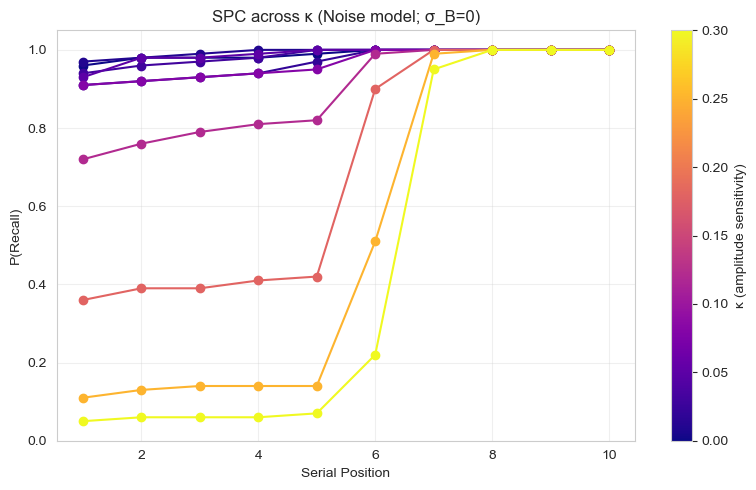

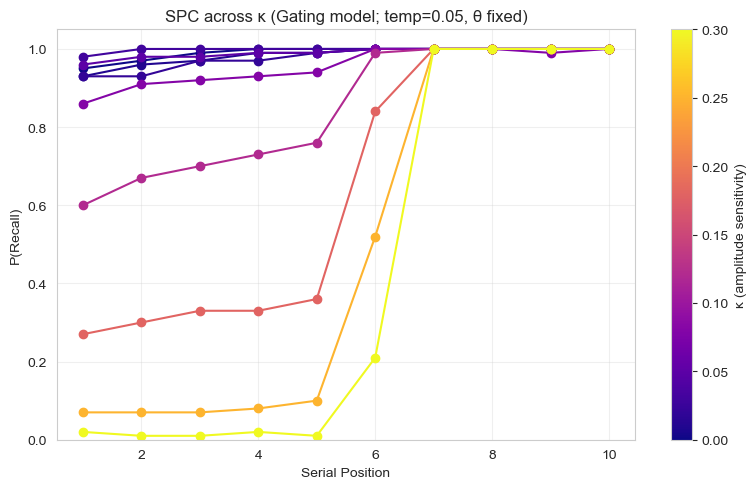

In [20]:
# Plot SPC curves across κ (noise vs gating)

plot_spc_curves_1d(
    results_kappa_noise,
    kappa_grid,
    title="SPC across κ (Noise model; σ_B=0)",
    colorbar_label="κ (amplitude sensitivity)"
)

plot_spc_curves_1d(
    results_kappa_gating,
    kappa_grid,
    title=f"SPC across κ (Gating model; temp={temp_fixed:.2f}, θ fixed)",
    colorbar_label="κ (amplitude sensitivity)"
)


In [21]:
# ===== Sweep 1: σ_B only (noise model), κ fixed at 0.03 =====
results_sigma_noise = {}

for idx, sigma_B in enumerate(sigma_B_grid):
    seed = 4000 + idx

    recall_sims, times_sims, net_w_fc, net_w_cf = run_simulation(
        B_rec=B_rec_fixed,
        n_sims=n_sims,
        seed=seed,
        rewards=rewards,
        rl_alpha=rl_alpha_fixed,
        kappa=float(kappa_star),
        det_param=float(sigma_B),
        mapping_mode="noise",
        theta=theta_fixed,
        urpe_scale_mode=urpe_scale_mode,
        use_soft_gate=use_soft_gate
    )
    lag_vals, lag_probs = compute_lag_crp(recall_sims, N)
    results_sigma_noise[float(sigma_B)] = {
        "SPC": compute_spc(recall_sims, N),
        "PFR": compute_pfr(recall_sims, N),
        "recall_sims": recall_sims,
        "lag_vals": lag_vals,
        "lag_probs": lag_probs
    }

print("Done: σ_B sweep (noise model).")


Done: σ_B sweep (noise model).


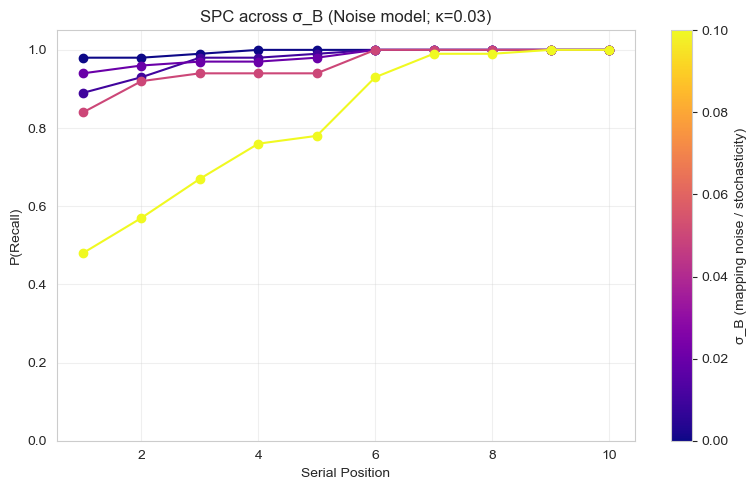

In [22]:
plot_spc_curves_1d(
    results_sigma_noise,
    sigma_B_grid,
    title=f"SPC across σ_B (Noise model; κ={kappa_star:.2f})",
    colorbar_label="σ_B (mapping noise / stochasticity)"
)


In [23]:
# ===== Sweep 2: temp only (gating model), κ fixed at 0.03 =====
results_temp_gating = {}

for idx, temp in enumerate(temp_grid):
    seed = 5000 + idx

    recall_sims, times_sims, net_w_fc, net_w_cf = run_simulation(
        B_rec=B_rec_fixed,
        n_sims=n_sims,
        seed=seed,
        rewards=rewards,
        rl_alpha=rl_alpha_fixed,
        kappa=float(kappa_star),
        det_param=float(temp),
        mapping_mode="gating",
        theta=theta_fixed,
        urpe_scale_mode=urpe_scale_mode,
        use_soft_gate=use_soft_gate
    )
    lag_vals, lag_probs = compute_lag_crp(recall_sims, N)
    results_temp_gating[float(temp)] = {
        "SPC": compute_spc(recall_sims, N),
        "PFR": compute_pfr(recall_sims, N),
        "recall_sims": recall_sims,
        "lag_vals": lag_vals,
        "lag_probs": lag_probs
    }

print("Done: temp sweep (gating model).")


Done: temp sweep (gating model).


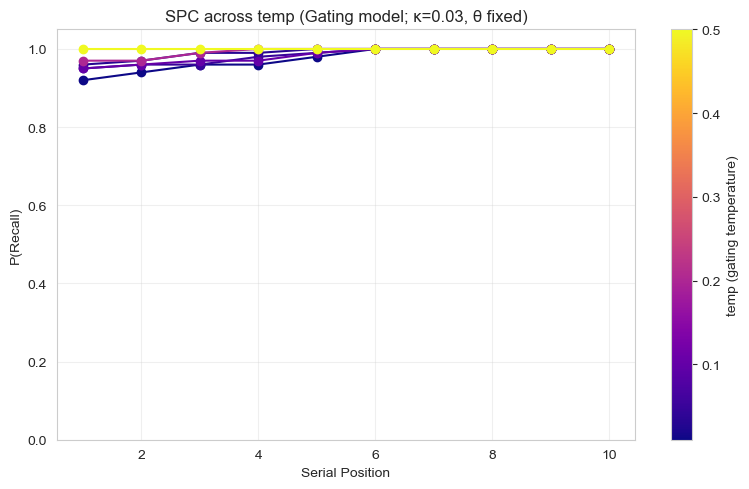

In [24]:
plot_spc_curves_1d(
    results_temp_gating,
    temp_grid,
    title=f"SPC across temp (Gating model; κ={kappa_star:.2f}, θ fixed)",
    colorbar_label="temp (gating temperature)"
)


### Baseline recovery sanity check

Because modulation is additive in κ and κ=0 removes it, both models should match the baseline drift schedule when κ=0 (up to simulation noise).


In [25]:
# Baseline check: κ=0 should recover baseline behavior (for both models)

baseline_noise = results_kappa_noise[0.0]
baseline_gating = results_kappa_gating[0.0]

print("BASELINE SPC (Noise model; κ=0, σ_B=0):", np.round(baseline_noise["SPC"], 3))
print("BASELINE SPC (Gating model; κ=0, temp fixed):", np.round(baseline_gating["SPC"], 3))


BASELINE SPC (Noise model; κ=0, σ_B=0): [0.96 0.98 0.98 0.98 0.99 1.   1.   1.   1.   1.  ]
BASELINE SPC (Gating model; κ=0, temp fixed): [0.95 0.97 0.99 1.   1.   1.   1.   1.   1.   1.  ]
